In [2]:
#Dependencies and Pre-processing
from rake_nltk import Rake
import pandas as pd
import requests
from IPython.display import Image, display
from timeit import default_timer as timer
import pprint
import sys
from timeit import default_timer as timer
import gensim
import string
from gensim.models import word2vec
import numpy as np
Songs = pd.read_csv("songdata.csv")
Songs.set_index("song",inplace=True)
Songs.drop(["artist","link"],inplace=True,axis=1)
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', limit=1000000, binary=True)


In [3]:
#Get images and tags in images
def get_images_and_tags(paragraphs):
    for p in paragraphs:
        p['imgs']= []
        for kw in p['keywords']:
            for img in pixabay_get([kw],50):
                if (img): p['imgs'].append(img)

In [4]:
# Map Paragraphs to Keywords
def paragraph_to_keywords_mapper(paragraphs):
    for p in paragraphs:
        listofkeywords = extract_kw(p['text'])
        if (listofkeywords == []):
            paragraphs.remove(p)
            continue
        p['keywords'] = listofkeywords
    

In [5]:
#Functions
def pixabay_get(keywords,N):
    r = requests.get('https://pixabay.com/api/?key=6713313-c85a6d8e3f6fe1a13b85f7d78&q='+"+".join(keywords)+'&image_type=photo&page=1&per_page='+str(N))
    result=[]
    try:
        for img in r.json()['hits']:
            result.append({'url':img['webformatURL'], 'tags':img["tags"].split(", ")})
    except:
        pass
    return result

def fragment(lyrics):
    paragraphs = []
    paragraphs = lyrics.split('\n  \n')
    if (len(paragraphs)==1):
        paragraphs = lyrics.split('  \r\n  ')
    return [{'text':x} for x in paragraphs]

def extract_kw(text):
    rake = Rake()
    rake.extract_keywords_from_text(text)
    A = rake.get_ranked_phrases_with_scores()
    if not A:
        return []
    return [x[1] for x in A]

def Para_to_Keywords(paragraphs):
    for p in paragraphs:
        listofkeywords = extract_kw(p['text'])
        if (listofkeywords == []):
            paragraphs.remove(p)
            continue
        p['keywords'] = listofkeywords


Paragraph 1: https://pixabay.com/get/e832b80f2ff4003ed95c4518b74a4197e074e3d604b0144095f6c971a0e4b4_640.jpg


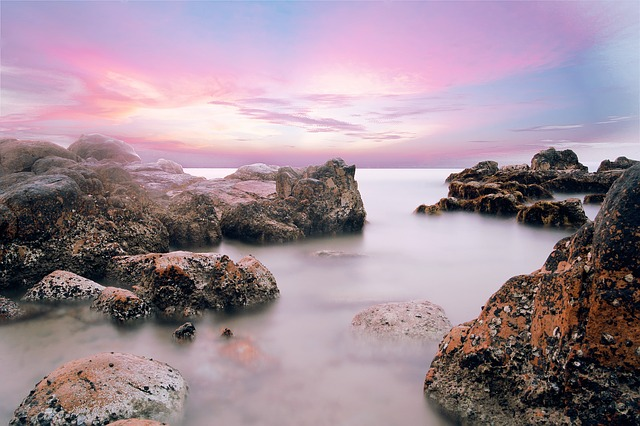

Paragraph 2: https://pixabay.com/get/e83db30b20f1043ed95c4518b74a4197e074e3d604b0144095f6c971a0e4b6_640.jpg


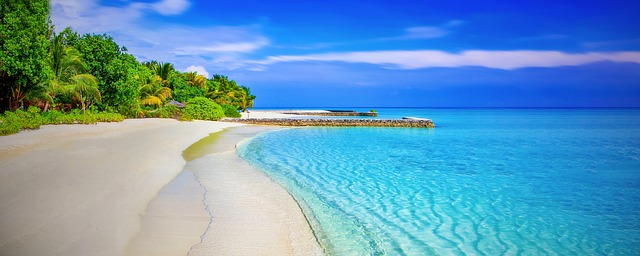

Paragraph 3: https://pixabay.com/get/e833b30a2cf3063ed95c4518b74a4197e074e3d604b0144095f6c971a0e4b2_640.jpg


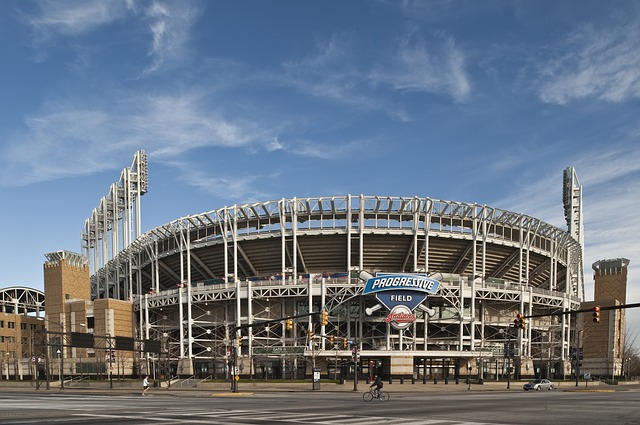

Paragraph 4: https://pixabay.com/get/ef3cb00d2afd1c2ad65a5854e04b4795e076e1c818b4104193f8c971a7ec_640.jpg


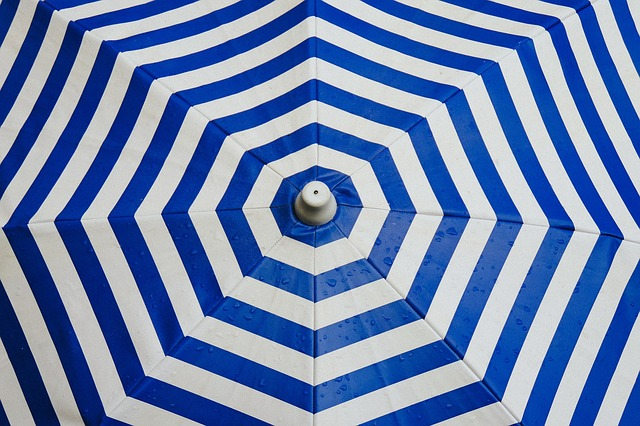

Paragraph 5: https://pixabay.com/get/eb3db40b2cf1023ed95c4518b74a4197e074e3d604b0144095f6c971afedbc_640.jpg


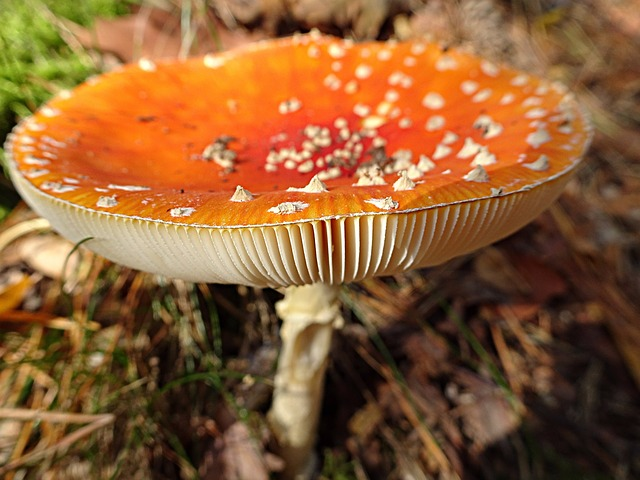

Paragraph 6: https://pixabay.com/get/e833b30a2cf3063ed95c4518b74a4197e074e3d604b0144095f6c971afecb7_640.jpg


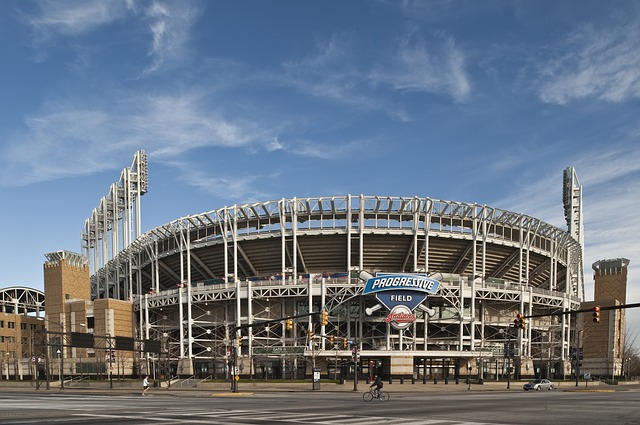

Paragraph 7: https://pixabay.com/get/e833b30a2cf3063ed95c4518b74a4197e074e3d604b0144095f6c971afecb0_640.jpg


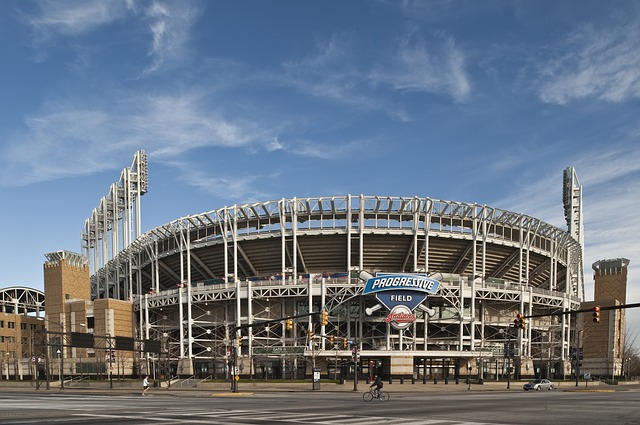

In [ ]:
#Choose a song
lyrics = Songs.iloc[101]["text"]

################################################################

#Fragment into paragraphs
paragraphs = fragment(lyrics)

################################################################

paragraph_to_keywords_mapper(paragraphs)
get_images_and_tags(paragraphs)

#Compare vectors and Pick the most relevent image for each paragraph

# Calculate kw_avg vector for each image 
for p in paragraphs:
    kw_avg=np.zeros(300)
    kw_count=0
    for kw in p['keywords']:
        for kw_nospace in kw.split(' '):
            try: 
                kw_avg += model.wv[kw_nospace]
                kw_count += 1
            except: # ignore if keyword is not found by the model
                pass
    if (kw_count > 0):
        kw_avg /= kw_count
        p['kw_avg']=kw_avg

# Calculate vector for each image
for p in paragraphs:
    for img in p['imgs']:
        img_tag_avg = np.zeros(300)
        img_tag_count = 0
        for tag in img['tags']:
            img_tag_count += 1
        try:
                img_tag_avg += model.wv[tag]
        except:
                pass
        if (img_tag_count>0):
            img['vector'] = img_tag_avg / img_tag_count
            
#Pick the most relevent image
filtered = []
for p in paragraphs:
    difference = np.inf
    picked_url = ''
    for img in p['imgs']:
        if (difference > np.sum(np.abs(p['kw_avg'] - img['vector']))):
            if filtered:
                if (img['url'] in filtered):
                    continue
            difference = np.sum(np.abs(p['kw_avg'] - img['vector']))
            picked_url = img['url']
    p['picked_url'] = picked_url 
    filtered.append(picked_url)

    

################################################################################
# Display
for i,p in enumerate(paragraphs):
    print('Paragraph ' + str(i+1) + ': ' +p['picked_url'])
    display(Image(p['picked_url'],height=400,width=400,embed=True))

In [ ]:
#Choose a song
lyrics = Songs.iloc[122]["text"]

################################################################

#Fragment into paragraphs
paragraphs = fragment(lyrics)

################################################################

paragraph_to_keywords_mapper(paragraphs)
get_images_and_tags(paragraphs)

#Compare vectors and Pick the most relevent image for each paragraph

# Calculate kw_avg vector for each image 
for p in paragraphs:
    kw_avg=np.zeros(300)
    kw_count=0
    for kw in p['keywords']:
        for kw_nospace in kw.split(' '):
            try: 
                kw_avg += model.wv[kw_nospace]
                kw_count += 1
            except: # ignore if keyword is not found by the model
                pass
    if (kw_count > 0):
        kw_avg /= kw_count
        p['kw_avg']=kw_avg

# Calculate vector for each image
for p in paragraphs:
    for img in p['imgs']:
        img_tag_avg = np.zeros(300)
        img_tag_count = 0
        for tag in img['tags']:
            img_tag_count += 1
        try:
                img_tag_avg += model.wv[tag]
        except:
                pass
        if (img_tag_count>0):
            img['vector'] = img_tag_avg / img_tag_count
            
#Pick the most relevent image
filtered = []
for p in paragraphs:
    difference = np.inf
    picked_url = ''
    for img in p['imgs']:
        if (difference > np.sum(np.abs(p['kw_avg'] - img['vector']))):
            if filtered:
                if (img['url'] in filtered):
                    continue
            difference = np.sum(np.abs(p['kw_avg'] - img['vector']))
            picked_url = img['url']
    p['picked_url'] = picked_url 
    filtered.append(picked_url)
    

    

################################################################################
# Display
for i,p in enumerate(paragraphs):
    print('Paragraph ' + str(i+1) + ": " + p['picked_url'])
    display(Image(p['picked_url'],height=400,width=400,embed=True))
    

In [14]:
A = Songs.iloc[122]["text"]
pprint.pprint(A.split('\n  \n'))

["I'm never gonna say I'm sorry,  \n"
 "I'm a clown for everyone  \n"
 "I'm never gonna let you down,  \n"
 "I'm always here like a sun  ",
 "I'm a looser, that is a fact for sure  \n"
 "I'm happy even if you don't want  \n"
 'To invite me out for a dance tonight  \n'
 "I'm not normal, I know, I don't care  \n"
 "I'm never gonna say  ",
 "I'm always here like a sun, I'm always here  \n"
 'Like a ghost I follow your steps so true  \n'
 "You don't have to bribe me or fill me up  \n"
 'Give me just a minute to shine with you  \n'
 'I will make you so happy, make you laugh  \n'
 "I'm never gonna say I'm sorry for  ",
 'The essence of my soul  \n'
 "There's so many ways to change my life  \n"
 "'Cause I want to, oh  \n"
 "I'm like a clown, I'm fun for everyone,  \n"
 "I'm never gonna say I'm sorry\n"
 '\n']


In [15]:
A = Songs.iloc[101]["text"]
pprint.pprint(A.split('\n  \n'))

['Come to my loveland, wander along  \n'
 'Beautiful gardens full of flowers and songs  \n'
 'Come to the sunshine, beaches and sand  \n'
 "Here's the two bluebirds, won't you come to my land  ",
 'The grass is mellow and the sky is blue  \n'
 'My paradise is waiting here for you  ',
 "Oh, it's a tropical loveland  \n"
 'Oh, I want to share it with you  \n'
 'Life can be funny  \n'
 'Happy and sunny  \n'
 'Oh, in my tropical loveland  ',
 'Come to my loveland, wander with me  \n'
 'Lie with me darling in the shade of a tree  \n'
 'Over the rainbow, under the moon  \n'
 "That's where my land is, won't you come to me soon?  ",
 "Just take my hand, I'll show you everything  \n"
 'The secrets that my paradise can bring  ',
 "Oh, it's a tropical loveland  \n"
 'Oh, I want to share it with you  \n'
 'Life can be funny  \n'
 'Happy and sunny  \n'
 'Oh, in my tropical loveland  ',
 "Oh, it's a tropical loveland  \n"
 'Oh, I want to share it with you  \n'
 '(I want to share it with you)  \n'
 "

In [16]:
import numpy as np
import matplotlib.pyplot as plt

img_A = np.ones((10,10))
img_B = np.ones((10,10))

plot_image = np.concatenate((img_A, img_B), axis=1)

plt.imshow(plot_image)


In [25]:
img_A   = Image('https://pixabay.com/get/eb33b90c2dfc033ed95c4518b74a4197e074e3d604b0144095f1c479afeabc_640.png',height=400,width=400,embed=True)
img_B   = Image('https://pixabay.com/get/e83db30b20f1043ed95c4518b74a4197e074e3d604b0144095f1c471afedb0_640.jpg',height=400,width=400,embed=True)

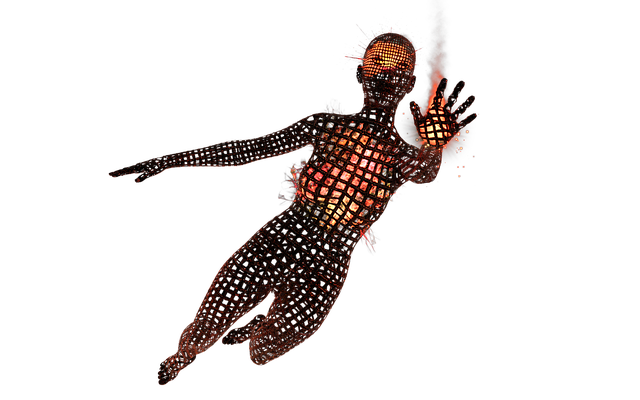

In [26]:
img_A

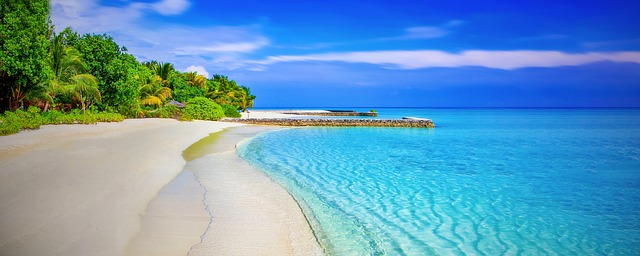

In [27]:
img_B